___

# Natural Language Processing Project

In this NLP project we will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. We will utilize the sklearn pipeline methods for more complex tasks.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

Let's get started!

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

sns.set_theme()
%matplotlib inline

## The Data

Let's read the yelp.csv file and set it as a dataframe called yelp.

In [2]:
yelp = pd.read_csv('data/yelp.csv')

Now we use the head, info, and describe methods on yelp.

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,10000.0,3.7775,1.214636,1.0,3.0,4.0,5.0,5.0
cool,10000.0,0.8768,2.067861,0.0,0.0,0.0,1.0,77.0
useful,10000.0,1.4093,2.336647,0.0,0.0,1.0,2.0,76.0
funny,10000.0,0.7013,1.907942,0.0,0.0,0.0,1.0,57.0


To start, we create a new column called "text length" which is the length in the text column.

In [6]:
yelp['text length'] = yelp['text'].apply(len)
print("New feature ('text length') description: ")
print(yelp['text length'].describe())

New feature ('text length') description: 
count    10000.000000
mean       714.199700
std        620.863509
min          1.000000
25%        295.000000
50%        544.000000
75%        936.000000
max       5039.000000
Name: text length, dtype: float64


## EDA

Let's explore the data! For first, we use FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings.

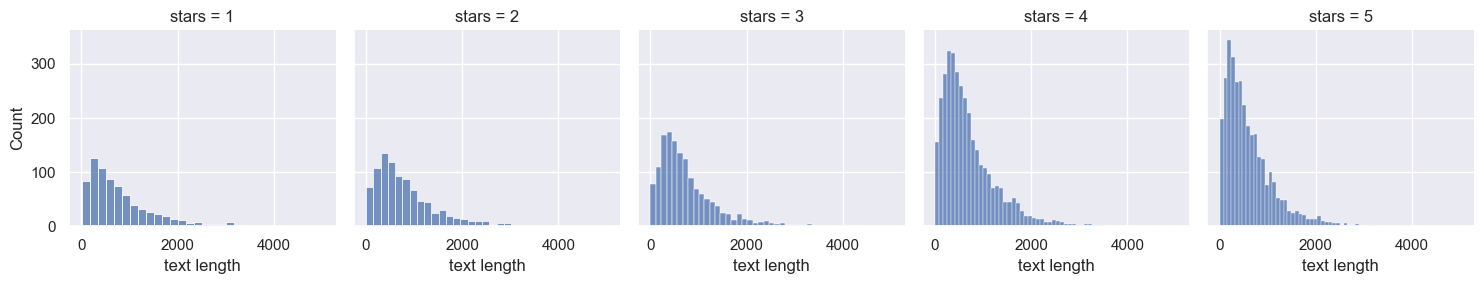

In [7]:
g = sns.FacetGrid(yelp, col='stars')
g.map_dataframe(sns.histplot, x='text length')

We can notice a review text length increment with more stars. 

Now, let's pass instead to a boxplot of text length for each star category.

<AxesSubplot: xlabel='stars', ylabel='text length'>

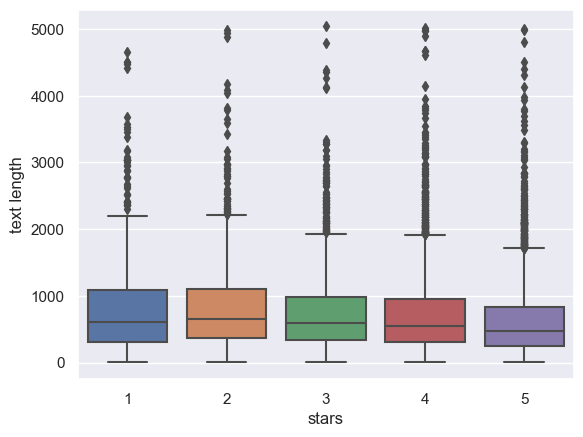

In [8]:
sns.boxplot(yelp, x='stars', y='text length')

Countplot of the number of occurrences for each type of star rating:

<AxesSubplot: xlabel='stars', ylabel='count'>

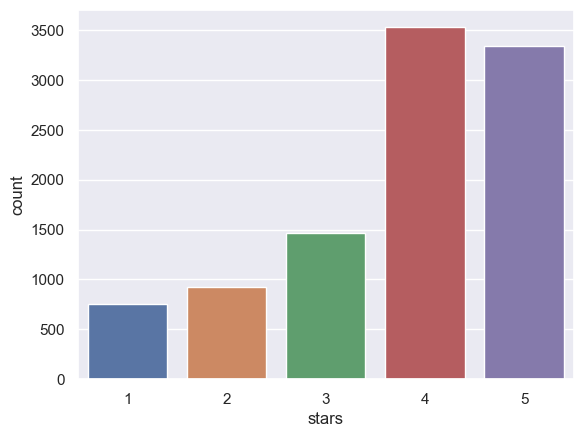

In [9]:
sns.countplot(data=yelp, x='stars')

It's time now to group the features by stars and see the correlations among them. Let's start by creating the Dataframe:

In [10]:
groupByStars = yelp.groupby('stars').mean(numeric_only=True)
groupByStars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,830.244326
2,0.719525,1.563107,0.875944,846.249191
3,0.788501,1.306639,0.694730,762.325120
4,0.954623,1.395916,0.670448,716.493193
5,0.944261,1.381780,0.608631,627.976925


Then we'll use the *corr()* method on that groupby dataframe to analyze the correlation of the feature, also visualizing them in a heatmap:

In [11]:
groupByStarsCorr = groupByStars.corr()
groupByStarsCorr

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.856995
useful,-0.743329,1.000000,0.894506,0.698743
funny,-0.944939,0.894506,1.000000,0.842585
text length,-0.856995,0.698743,0.842585,1.000000


<AxesSubplot: >

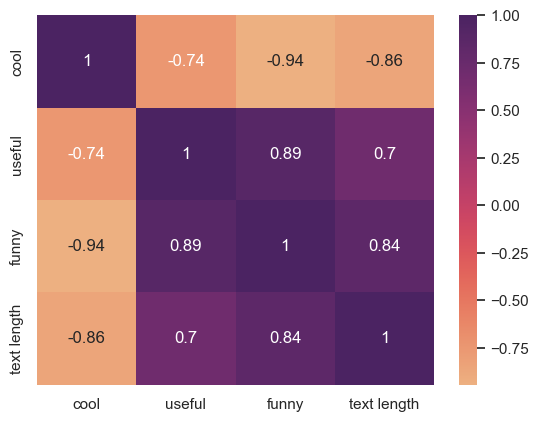

In [12]:
sns.heatmap(groupByStarsCorr, annot=True, cmap='flare')

## NLP Classification Task


Let's move on to the actual task. To make things a little easier, for this project we only grab reviews that were either 1 star or 5 stars.

In [13]:
yelp_class = yelp.query('stars == 1 | stars == 5')
yelp_class.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,895
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1349
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,423
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,471
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1571


### Preparing the data

What we do now is to create two objects, **X** and **y**. **X** will be the 'text' column of yelp_class and **y** will be the 'stars' column of yelp_class (in other words, our features and target/labels).

In [14]:
X = yelp_class['text']
y = yelp_class['stars']

Now, what we'll be using the CountVectorizer object from scikit-learn to transform our "text" feature into bag-of-words. We'll have a sparse matrix where, for each unique word, the number of occurences will be memorized.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

Let's use the fit_transform method on the CountVectorizer object and pass in X.

In [16]:
X = CountVectorizer().fit_transform(X)

### Train Test Split

Let's split our data into training and testing data.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=.3)

### Training a Model

Time to train a model! For this project, a multinomial Naive Bayes will be used. A multinomial Naive Bayes model will take in account especially the occurence rate of each word in each review.

To use this model, we'll import the *MultinomialNB* object from sklearn, fitting it with our train data.

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
model = MultinomialNB()

In [21]:
model.fit(X_train, y_train)

MultinomialNB()

### Predictions and Evaluations

Time to see how well our model was!

In [22]:
preds = model.predict(X_test)

To analyze the model performance, we'll use the confusion matrix and the classification report as metrics.

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[159  69]
 [ 22 976]]
              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



Great! Let's see what happens if we try to include TF-IDF to this process using a pipeline.

### Using Text Processing

What we do now is the same classification task, but preceded by a text processing. In particular, what we are goin to use is TF-IDF (*Term Frequency-Inverse Document Frequency*), a weight measure often use in the information retrieval and data mining fields.

Typically, the TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

To convert our bag-of-words for each review into the TF-IDF measure, we'll use the TfidfTransformer from sklearn.

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

Since the steps that we are going to follow may be of use for other future jobs, we'll save our workflow into a sklearn Pipeline. The pipeline will contain:
- the **CountVectorizer** (from strings to integer counts/bag-of-words)
- the **TfidfTransformer** (integer-counts to td-idf scores)
- the **MultinomialNB** (train on TF-IDF vectors our Multinomial Naive Bayes classifier).

In [26]:
from sklearn.pipeline import Pipeline

In [27]:
pipeline = Pipeline([
  ('bow', CountVectorizer()),
  ('tf-idf', TfidfTransformer()),
  ('model', MultinomialNB())  
])

#### Using the Pipeline

Time to use the pipeline for our classification task! Since the pipeline contains all of our pre-processing operations, we are going to split again the *yelp_class* dataset.

#### Train Test Split

In [28]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=101)

Now let's fit the pipeline to the training data. Recall that we can't use the same training data as last time because that data has already been vectorized: we need to pass again the text and labels.

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tf-idf', TfidfTransformer()),
                ('model', MultinomialNB())])

### Predictions and Evaluation

In [30]:
preds = pipeline.predict(X_test)

In [31]:
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[  0 228]
 [  0 998]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Looks like TF-IDF actually made things worse! Bruh.

But there is a thing we can do to try to fix it: a custom text analyzer. We'll pass to the CountVectorizer a function that will clean every text reviews from punctuation and stopwords. here's the function down below: 

In [32]:
import string
from nltk.corpus import stopwords

def text_process(text):
  """
  Function to pre-process text before being
  transformed into bag-of-words 
  """
  
  # check for punctuation, joining the caracted again
  # to obtain the text without punctuation
  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)
  
  # remove the stopwords
  return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    

We'll create a new skelarn Pipeline. It'll be identical to the previous one, but with the CountVectorizer with the "text_process" function.

In [42]:
pipeline = Pipeline([
  ('bow', CountVectorizer(analyzer=text_process)),
  ('tf-idf', TfidfTransformer()),
  ('model', MultinomialNB())
])

Let's train our model and make prediction with this new addiction.

In [34]:
# resplit our dataset
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=101)

In [35]:
# model train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001516D1EFE20>)),
                ('tf-idf', TfidfTransformer()), ('model', MultinomialNB())])

In [36]:
# retrieve predictions
preds = pipeline.predict(X_test)

In [38]:
# print evaluations
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[  0 228]
 [  0 998]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Even with some text pre-processing, that cannot be of any help to mitigate the classification issue. The last thing we can do is to change the model we are using. Let's try change our pipeline with a LogisticRegression model:

In [41]:
from sklearn.linear_model import LogisticRegression

# new pipeline
pipeline = Pipeline([
  ('bow', CountVectorizer(analyzer=text_process)),
  ('tf-idf', TfidfTransformer()),
  ('model', LogisticRegression())
])

# train test split
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=.3)

# model train
pipeline.fit(X_train, y_train)

# model predictions and evaluation
preds = pipeline.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[ 65 163]
 [  2 996]]
              precision    recall  f1-score   support

           1       0.97      0.29      0.44       228
           5       0.86      1.00      0.92       998

    accuracy                           0.87      1226
   macro avg       0.91      0.64      0.68      1226
weighted avg       0.88      0.87      0.83      1226



Changing model actually helps! The reason why the Multinomial naive Bayes Classifier was less effective in this task may rely on the assuption that the NB itself does: that is, having all variables independent. Usually this assumptions is impractical in real life language context (and so also in reviews like the ones we have in the dataset), due to the fact that words tends to have an effect on each other. 

For the sake of the classification experiment, we repeat the task one last time, but without the *TfidfTransformer*:

In [43]:
from sklearn.linear_model import LogisticRegression

# new pipeline
pipeline = Pipeline([
  ('bow', CountVectorizer(analyzer=text_process)),
  ('model', LogisticRegression())
])

# train test split
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=.3)

# model train
pipeline.fit(X_train, y_train)

# model predictions and evaluation
preds = pipeline.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[155  73]
 [ 26 972]]
              precision    recall  f1-score   support

           1       0.86      0.68      0.76       228
           5       0.93      0.97      0.95       998

    accuracy                           0.92      1226
   macro avg       0.89      0.83      0.85      1226
weighted avg       0.92      0.92      0.92      1226



We receive more or less the same result of the the Multinomial Naive bayes without a TF-IDF metrix. Nice.


*That's the end of the project. I did it especially to experiment with classification manipulating text data, which is a really fascinating topic in my opinion.*